In [1]:
import torch, platform
print("CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

CUDA available? True
Device: NVIDIA A2


In [2]:
device = (
    torch.device('cuda') if torch.cuda.is_available()
    else torch.device('mps') if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else torch.device('cpu')
)
print("Using device:", device)

Using device: cuda


In [3]:
# from google.colab import files
# uploaded = files.upload()        # choose heatEquation_data.mat

In [4]:
!pip install pyDOE

In [5]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')
import os
# import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.sparse as sp
import scipy.sparse.linalg as la
from pyDOE import lhs
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, FuncFormatter
from matplotlib.ticker import FormatStrFormatter
import copy

<hr>

# Reconstructing the entire solution to the 1D heat equation using Neural Networks

<div style="padding: 10px;">

**Model Problem: 1D Heat Equation**

We begin by describing the first model problem - the one-dimensional heat equation.

The heat equation is the prototypical parabolic partial differential equation and can be applied to modelling the diffusion of heat through a given region. Read more about the heat equation here: [https://en.wikipedia.org/wiki/Heat_equation](https://en.wikipedia.org/wiki/Heat_equation).

In 1D, the heat equation can be written as:

\begin{equation}
\frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2 },
\end{equation}
    
where $k$ is a material parameter called the coefficient of thermal diffusivity.

This equation can be solved using numerical methods, such as finite differences or finite elements. For this notebook, we will solve for $u(x,t)$ the above equation numerically on a domain of $x \in [0,1]$ and $t \in [0, 0.25]$.

The procedure in this notebook is the following:
- read in a dataset that describes an exact solution to the heat equation. This is treated as the benchmark to which any reconstruction is compared.
- downsample the dataset to get a sparse collection of "measurements".
- Using this sparse dataset, with knowledge of the physics, attempt to reconstruct the entire solution.
- Evaluating this solution at $t=0$ gives the initial profile, thus solving the inverse problem of finding the initial state.
</div>

In [6]:
# data = scipy.io.loadmat('/content/heatEquation_data.mat')

<div style="padding: 10px;">

# Configuring the network
      
A feedforward neural network of the following structure is assumed:
- the input layer (with two inputs: $x$ and $t$) takes 2D data $(x,t)$ scaled elementwise to lie in the interval $[-1, 1]^2$,
- this is followed by 8 fully connected layers each containing 20 neurons and each using a hyperbolic tangent activation function,
- one fully connected output layer with a single neuron.

We can count up the number of unknowns:

- The first fully connected layer has 20 neurons, each of which has two inputs and one bias term, a total of $20 \cdot 3 = 60$ unknowns.
- The remaining 7 fully connected layers each have 20 neurons with 20 inputs and a bias term, a total of $7 \cdot 20 \cdot 21=2940$ unknowns.
- The final output layer has 1 neuron with 20 inputs and one bias, a total of 21 unknowns.

Overall, the network has 3021 unknown weights and bias terms.
    

</div>

In [7]:
# structure of network: two inputs (x,t) and one output u
# 8 fully connected layers with 20 nodes per layer
layers = [3, 50, 50, 50, 1]

 <div style="padding: 10px;">
    
# Sampling of data and collocation

We make the choices of:
- `N_u` (e.g. 100) data points that will constrain the network
- `N_f` collocation points (e.g. 3000) to implement the physics-informed constraint.
- `k=1` as the coefficient of diffusivity

Once you have run through the notebook once you may wish to alter any of the sampling or network configuration parameters.

Note that in this example we have more constraints on the network (3100) than free parameters (3021), but this will change depending on network configuration.
</div>


In [8]:
# Number of points for IC/BC and in k
N_i = 101   # spatial points in initial condition
N_b = 51    # time points on each boundary, so 2*N_b total
N_k = 51    # number of parameter samples in k

N_u = N_i + 2 * N_b  # (not counting k): base count in x,t per k
N_f = 1000           # Collocation points (PDE residual)
N_val = 100          # Validation points (PDE + analytic solution)

<hr>
<div style="padding: 10px;">
    
###  Reformat input data  
    
The data comes from a file, containing lists of x and t and the solution on the associated grid.
Unfortunately we need it in a different format!

Variables that are defined here:

`Exact` - this is the solution read in from the file. It is the benchmark to which we will compare any reconstruction.

`X_star` - a vector of (x,t) coordinate pairs. This contains the boundary points (note this for later!)

`u_star` - the associated solution (a reformatted version of `Exact`)

`lb`: Vector containing the lower bound of all of the coordinate variables, e.g. $x_{min}$, $t_{min}$.

`ub`: Vector containing the upper bound of all of the coordinate variables, e.g. $x_{max}$, $t_{max}$.


</div>

In [9]:
# t = data['t'].flatten()[:,None] # read in t and flatten into column vector
# x = data['x'].flatten()[:,None] # read in x and flatten into column vector
#  # Exact represents the exact solution to the problem, from the data provided
# Exact = np.real(data['usol']).T # Exact has structure of nt times nx

# print("usol shape (nt, nx) = ", Exact.shape)

# # We need to find all the x,t coordinate pairs in the domain
# X, T = np.meshgrid(x,t)

# # Flatten the coordinate grid into pairs of x,t coordinates
# X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) # coordinates x,t
# u_star = Exact.flatten()[:,None]   # corresponding solution value with each coordinate


# print("X has shape ", X.shape, ", X_star has shape ", X_star.shape, ", u_star has shape ", u_star.shape)

# # Domain bounds (-1,1)
# lb = X_star.min(axis=0)
# ub = X_star.max(axis=0)

# print("Lower bounds of x,t: ", lb)
# print("Upper bounds of x,t: ", ub)
# print('')
# print('The first few entries of X_star are:')
# print( X_star[0:5, :] )

# print('')
# print('The first few entries of u_star are:')
# print( u_star[0:5, :] )

<div style="padding: 10px;">

## Select collocation points

We now randomly select the `N_f` collocation points for the physics constraints. We do this using Latin Hypercube Sampling
https://en.wikipedia.org/wiki/Latin_hypercube_sampling

producing:
-  `X_f_train` the coordinates of the collocation set

## Select data points

Randomly select `N_u` points from the original dataset, producing:
-  `X_u_train` the coordinates of the training set
-  `u_train` the corresponding value of the solution value.

</div>

In [10]:
# Generate training data
# Domain boundaries
x_min, x_max = 0.0, 1.0
t_min, t_max = 0.0, 0.25

# --- Parametric diffusivity k in [0.2, 2.0] ---
k_min, k_max = 0.2, 2.0

# Log10-spaced k values:
#   - logk is uniformly spaced
#   - k itself is geometric (log-uniform)
logk_min = np.log10(k_min)
logk_max = np.log10(k_max)
rng = np.random.default_rng(123)
logk_vec = rng.uniform(logk_min, logk_max, N_k)  # random in [logk_min, logk_max]
logk_vec = np.sort(logk_vec)                     # optional: sort for nicer order
k_vec = 10.0**logk_vec    # physical k values for analytic solution shape (N_k,)

# --- Initial condition: u(x,0) = sin(pi x) ---
x_ic = np.linspace(x_min, x_max, N_i)
t_ic = [0.0]
x_ic_g, t_ic_g, logk_ic_g = np.meshgrid(x_ic, t_ic, logk_vec, indexing='ij')
x_u_ic = x_ic_g.ravel()[:, None]     # (Nx*Nt*Nk, 1)
t_u_ic = t_ic_g.ravel()[:, None]
logk_u_ic = logk_ic_g.ravel()[:, None]
X_u_train_ic = np.hstack([x_u_ic, t_u_ic, logk_u_ic])

# --- Boundary conditions: u(0,t) = 0, u(1,t) = 0 (example Dirichlet) ---
t_line = np.linspace(t_min, t_max, 2* N_b)
x_bc_left  = [0.0]
x_bc_right = [1.0]
x_bc = np.concatenate([x_bc_left, x_bc_right], axis=0)  # shape (2*N_b,)
x_bc_g, t_bc_g, logk_bc_g = np.meshgrid(x_bc, t_line, logk_vec, indexing='ij')
x_u_bc = x_bc_g.ravel()[:, None]     # (Nx*Nt*Nk, 1)
t_u_bc = t_bc_g.ravel()[:, None]
logk_u_bc = logk_bc_g.ravel()[:, None]
X_u_train_bc = np.hstack([x_u_bc, t_u_bc, logk_u_bc])

# Create a "data" set (X_u_train, u_train) from the analytic solution
# Includes:
#   - initial condition at t=0, all x, all k
#   - boundary conditions at x=0 and x=1, all t, all k
X_u_train = np.vstack([X_u_train_ic, X_u_train_bc]).astype(np.float32)

# Split columns for convenience
x_cal    = X_u_train[:, 0]
t_cal    = X_u_train[:, 1]
logk_cal = X_u_train[:, 2]
k_cal    = 10.0**logk_cal

# Closed-form solution u(x,t;k) = exp(-k π² t) sin(π x)
u_train = np.exp(-k_cal * (np.pi**2) * t_cal) * np.sin(np.pi * x_cal)   # shape (N,)
u_train = u_train[:, None].astype(np.float32)               # make it (N,1), float32 if you like


## Generate collocation points using Latin Hypercube sampling within the bounds of the spatio-temporal coordinates
# Generate N_f x, t, k coordinates within range of upper and lower bounds
# 1) Bounds (x_min, t_min, k_min) and (x_max, t_max, k_max)
lb = np.array([x_min, t_min, logk_min], dtype=np.float32)
ub = np.array([x_max, t_max, logk_max], dtype=np.float32)
np.random.seed(123)
U_all = lhs(3, samples=N_f + N_val)             # in [0,1]^3
X_all = lb + (ub - lb) * U_all                  # map to [lb, ub] (x, t, logk)
X_f_train = X_all[:N_f]                         # collocation points
X_val     = X_all[N_f:]                         # validation points 




print('')
print('The first few entries of X_u_train are:')
print( X_u_train[0:5] )

print('')
print('The first few entries of u_train are:')
print( u_train[0:5] )

print('')
print("Shapes of X_f_train and X_val are:")
print(f"X_f_train: {X_f_train.shape},  X_val: {X_val.shape}")


The first few entries of X_u_train are:
[[ 0.          0.         -0.6957889 ]
 [ 0.          0.         -0.69307995]
 [ 0.          0.         -0.6844955 ]
 [ 0.          0.         -0.6840751 ]
 [ 0.          0.         -0.67673475]]

The first few entries of u_train are:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Shapes of X_f_train and X_val are:
X_f_train: (1000, 3),  X_val: (100, 3)


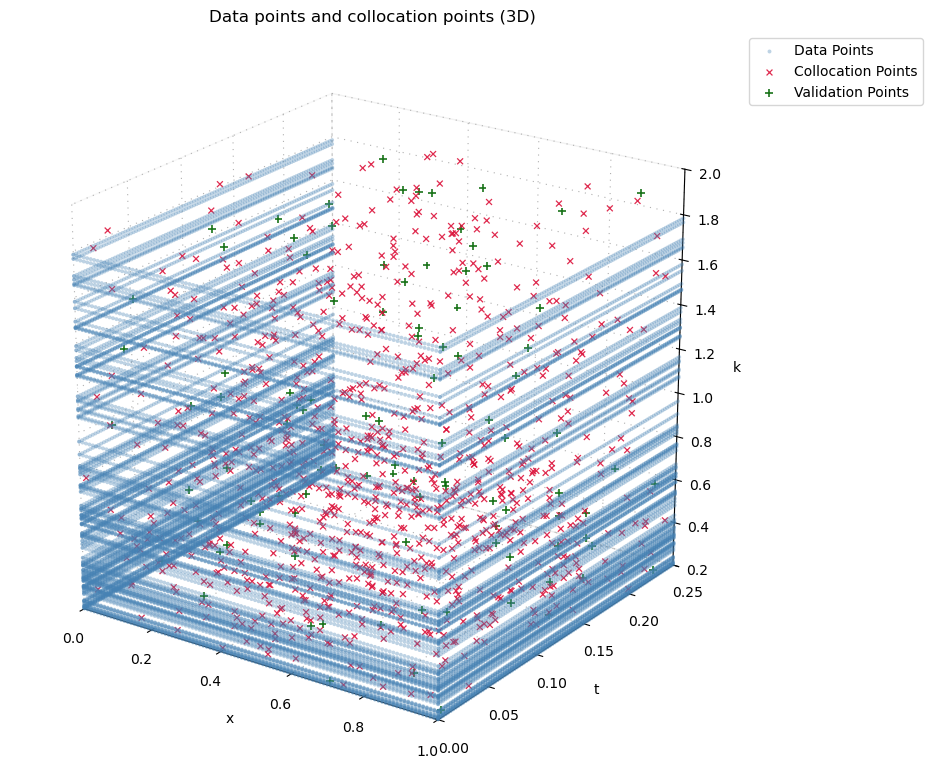

In [11]:
# --- downsample data for clarity ---
max_points = 50000
Nu = X_u_train.shape[0]
idx = np.random.choice(Nu, size=min(max_points, Nu), replace=False)
Xu = X_u_train[idx]  # (M, 3): (x, t, log10(k))
Xf = X_f_train       # (x, t, log10(k))
Xv = X_val           # (x, t, log10(k))

fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')

# Helper: convert log10(k) -> k for plotting
def logk_to_k_z(arr):
    return 10.0**arr[:, 2]

# Data (sampled): single color, slightly larger & clearer
ax.scatter(Xu[:,0], Xu[:,1], logk_to_k_z(Xu),
           c='steelblue', s=8, alpha=0.35, marker='o', linewidths=0,
           label='Data Points')

# Collocation & validation: distinct markers
ax.scatter(Xf[:,0], Xf[:,1], logk_to_k_z(Xf),
           marker='x', c='crimson', s=18, alpha=0.9, linewidths=0.9,
           label='Collocation Points')
ax.scatter(Xv[:,0], Xv[:,1], logk_to_k_z(Xv),
           marker='+', c='darkgreen', s=32, alpha=0.9, linewidths=1.2,
           label='Validation Points')

# Labels & title
ax.set_xlabel('x', labelpad=6)
ax.set_ylabel('t', labelpad=6)
ax.set_zlabel('k', labelpad=6)
ax.set_title('Data points and collocation points (3D)', pad=12)

# ---- Make the plot a cube (equal aspect ratio) ----
# Gather all points to compute a common cube box
all_pts = np.vstack([Xu, Xf, Xv])  # (N, 3)
mins = all_pts.min(axis=0)
maxs = all_pts.max(axis=0)
cent = (mins + maxs) / 2.0
span = (maxs - mins).max()         # largest span across x/t/k

ax.set_xlim(0, 1)
ax.set_ylim(0, 0.25)
ax.set_zlim(0.2, 2.0)
try:
    ax.set_box_aspect((1, 1, 1))   # mpl ≥ 3.3
except Exception:
    pass

# View & styling
ax.view_init(elev=22, azim=-55)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.pane.fill = False
    axis._axinfo["grid"]['linestyle'] = (0, (1, 5))

# Legend (outside)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)

plt.tight_layout()
plt.show()

<hr>
<div style="padding: 10px;">

## Encoding of the network and physics constraint
The function **$u(x,t)$** that we seek is defined below as the function `net_u`; the physics constraint **$f(x,t)$** is defined in the function `net_f`
    
    
1. we read in the value of k first so that it can be included in the equations
2. then we evaluate u for the X_f input coordinates (collocation points)
3. then we use pytorch differentiation (autograd) to calculate the derivatives of the solution
4. finally we encode the PDE in residual form, as f->0, u_t = k*u_xx, which is the governing equation
    
</div>



In [12]:
def u_true_numpy(X, T, logK):
    """Vectorised true solution: U = exp(-(pi^2) * T) * sin(pi * X)."""
    K = 10.0**logK    # convert log10(k) → k
    return np.exp(- K * (np.pi**2) * T) * np.sin(np.pi * X)

In [13]:
def net_u(x, t, logk, model):
    """
    NN input is (x, t, log10(k)).
    """
    X = torch.cat([x, t, logk], dim=1)  # If x and t are each shape (N, 1), then X becomes (N, 2).
    u = model(X)
    return u

# net_f computes the PDE residual
# If f ≈ 0 at collocation points, the NN satisfies the equation there
def net_f(x, t, logk, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    # logk.requires_grad_(True)
    
    u = net_u(x, t, logk, model)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    # convert log10(k) -> k = 10^logk
    k = 10.0**logk
    
    f = u_t - k * u_xx
    return f

# PyTorch module class and initialization

<div style="padding: 10px;">

This code sets up a Physics-Informed Neural Network (PINN) for solving the 1D heat equation using PyTorch. Here's a summary of the key components:

1. `XavierInit` Class:

Custom layer initialization using Xavier initialization (https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/), which is designed to keep the scale of the gradients roughly the same in all layers.
Initializes weights and biases for a layer.

2. `initialize_NN` Function:

Creates a list of layers using the XavierInit class.
Takes a list of layer sizes and initializes each layer accordingly.

3. `NeuralNet()` constructs the network where the input and output coordinates are normalised so that all values lie between -1 and 1; this improves training. Applies the layers sequentially with the tanh activation function, except for the last layer.


Using the PyTorch module classes allow you to create more complex models controlling exactly how the data flows through the model [overview of PyTorch Modules here](https://www.learnpytorch.io/02_pytorch_classification/)

</div>

In [14]:
class XavierInit(nn.Module):
    def __init__(self, size):
        super(XavierInit, self).__init__()
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = torch.sqrt(torch.tensor(2.0 / (in_dim + out_dim)))
        self.weight = nn.Parameter(torch.randn(in_dim, out_dim) * xavier_stddev)
        self.bias = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):
        return torch.matmul(x, self.weight) + self.bias

def initialize_NN(layers):
    weights = nn.ModuleList()
    num_layers = len(layers)
    for l in range(num_layers - 1):
        layer = XavierInit(size=[layers[l], layers[l + 1]]) # if there was no retutn, how do I get the weight and bias?
        weights.append(layer)
    return weights

class NeuralNet(nn.Module):
    def __init__(self, layers, lb, ub):
        super(NeuralNet, self).__init__()
        self.weights = initialize_NN(layers)
        # make lb/ub move with .to(device)
        self.register_buffer('lb', torch.as_tensor(lb, dtype=torch.float32))     # <<< CHANGED >>>
        self.register_buffer('ub', torch.as_tensor(ub, dtype=torch.float32))     # <<< CHANGED >>>
        # self.register_buffer('k', torch.tensor(k_init, dtype=torch.float32))     # <<< CHANGED >>>


    def forward(self, X):
        X = X.float()                                                            # <<< CHANGED >>>
        lb = self.lb.to(X.device)                                                # <<< CHANGED >>>
        ub = self.ub.to(X.device)                                                # <<< CHANGED >>>
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(len(self.weights) - 1):
            H = torch.tanh(self.weights[l](H.float()))     # Is this already a calculation?
        Y = self.weights[-1](H)
        return Y


In [15]:
l = XavierInit(size = [2, 3])
print(f"{l}")
print("weight shape:", l.weight.shape)
print("bias shape:", l.bias.shape)
print("weight:\n", l.weight)     # full tensor
print("bias:\n", l.bias)

XavierInit()
weight shape: torch.Size([2, 3])
bias shape: torch.Size([3])
weight:
 Parameter containing:
tensor([[ 0.6834, -0.0015,  0.9423],
        [ 0.9400,  0.4580, -0.9945]], requires_grad=True)
bias:
 Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


<div style="padding: 10px;">

### Note about Tensors in PyTorch

In PyTorch, tensors are the primary data structure used for storing and manipulating data. Below is an expanded explanation of setting up tensors, including requiring gradients and setting data types.

**Requiring Gradients**:
- To enable automatic differentiation, set `requires_grad=True` when creating a tensor. This allows PyTorch to track operations on the tensor and compute gradients during backpropagation.

**Data Types**:
  - PyTorch supports various data types, such as `float32`, `float64`, `int32`, `int64`, etc.
  - The data type can be specified using the `dtype` argument when creating a tensor, as your data types must match when performing operations


</div>

<div style="padding: 10px;">

## Training

1. Initialize Loss Function and Optimizer:

* criterion = `nn.MSELoss()`
* optimizer = `torch.optim.Adam(model.parameters(), lr=learning_rate)`

2. Prepare Input Data:

Extract `x` and `t` from `X`. Convert `x`, `t`, and `u` to PyTorch tensors with `requires_grad=True`.


3. Training Loop:

* Loop over the number of iterations (nIter).
* Zero the gradients: optimizer.zero_grad().
* Predict u and the residual f using the model: u_pred and f_pred.
* Compute the loss:
    * `loss_PDE`: Mean Squared Error (MSE) between `f_pred` and zero.
    * `loss_data`: MSE between `u_tf` and `u_pred`.
    * Total loss: loss = loss_PDE + 5*loss_data.
* Backpropagate the loss: `loss.backward()`.
* Update the model parameters: `optimizer.step()`.

4. Print Progress:

Every 500 iterations, print the current iteration, loss, and elapsed time.

</div>

In [16]:
def train(nEpoch, X, u, X_f, X_val, model, learning_rate):
    criterion = nn.MSELoss()
    
    # ----- STAGE 1: start with Adam -----
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # when to switch from Adam to L-BFGS
    switch_epoch = 3000
    used_lbfgs   = False   
    lbfgs_epochs   = 3000          # <-- how many epochs of L-BFGS you want
    lbfgs_start_ep = None          # <-- will store the epoch where we switch

    # use the model's device
    dev = next(model.parameters()).device                                        # <<< CHANGED >>>

    x    = X[:, 0:1]
    t    = X[:, 1:2]
    logk = X[:, 2:3]
    # Collocation points (f points)
    x_f    = X_f[:, 0:1]
    t_f    = X_f[:, 1:2]
    logk_f = X_f[:, 2:3]
    # Validation points
    x_v    = X_val[:, 0:1]
    t_v    = X_val[:, 1:2]
    logk_v = X_val[:, 2:3]

    # True validation solution (analytic)
    u_v_true = u_true_numpy(x_v, t_v, logk_v)   # shape (N_val,)

    # create tensors ON THE SAME DEVICE
    x_tf      = torch.tensor(x,        dtype=torch.float32, device=dev, requires_grad=True)   # <<< CHANGED >>>
    t_tf      = torch.tensor(t,        dtype=torch.float32, device=dev, requires_grad=True)   # <<< CHANGED >>>
    logk_tf   = torch.tensor(logk,     dtype=torch.float32, device=dev, requires_grad=True)   # <<< CHANGED >>>
    u_tf      = torch.tensor(u,        dtype=torch.float32, device=dev)                       # <<< CHANGED >>>
    x_f_tf    = torch.tensor(x_f,      dtype=torch.float32, device=dev, requires_grad=True)   # <<< CHANGED >>>
    t_f_tf    = torch.tensor(t_f,      dtype=torch.float32, device=dev, requires_grad=True)   # <<< CHANGED >>>
    logk_f_tf = torch.tensor(logk_f,   dtype=torch.float32, device=dev, requires_grad=True)   # <<< CHANGED >>>
    x_v_tf    = torch.tensor(x_v,      dtype=torch.float32, device=dev)
    t_v_tf    = torch.tensor(t_v,      dtype=torch.float32, device=dev)
    logk_v_tf = torch.tensor(logk_v,   dtype=torch.float32, device=dev)
    u_true_tf = torch.tensor(u_v_true, dtype=torch.float32, device=dev).reshape(-1, 1)

    mse_v_hist  = []
    loss_values = []
    max_errors  = []   # <<< NEW: to store (epoch, max_abs_error) >>>

    patience  = 10000          # number of validations without improvement
    pat       = 0
    best_v    = float('inf')   # best validation MSE
    best_TL   = float('inf')   # best training loss corresponding to best_v
    best_max_err = float('inf')  # <<< NEW: best max |error| on val
    best_state = copy.deepcopy(model.state_dict())
    best_ep    = -1

    start_time  = time.time()
    total_start = time.time()        # total wall-clock timer

    for ep in range(nEpoch):

        # ----- Stop if we've done lbfgs_epochs of L-BFGS -----
        if used_lbfgs and lbfgs_start_ep is not None:
            if ep - lbfgs_start_ep >= lbfgs_epochs:
                print(f"Stopping after {lbfgs_epochs} LBFGS epochs at global epoch {ep}")
                break

        # ------------------------------
        # STAGE 1: Adam (ep < switch_epoch)
        # STAGE 2: L-BFGS (ep >= switch_epoch)
        # ------------------------------
        if ep < switch_epoch:
            # ----- Adam update -----
            optimizer.zero_grad()
            
            # Compute predictions for training data (u)
            u_pred = net_u(x_tf, t_tf, logk_tf, model)          # <<< CHANGED
            # Compute PDE residual at collocation points
            u_f_pred = net_f(x_f_tf, t_f_tf, logk_f_tf, model)  # <<< CHANGED
    
            loss_PDE  = criterion(u_f_pred, torch.zeros_like(u_f_pred))
            loss_data = criterion(u_tf, u_pred)
            loss = loss_PDE + 100 * loss_data
    
            loss.backward()
            optimizer.step()
            
        else:
            # ----- Switch to L-BFGS once -----
            if not used_lbfgs:
                # 1) Load the best Adam weights BEFORE creating LBFGS
                model.load_state_dict(best_state)
        
                # 2) Print which Adam state you're starting from
                print(
                    f"Switching to L-BFGS at epoch {ep} "
                    f"-> starting from Adam best at epoch {best_ep} "
                    f"(TrainLoss={best_TL:.3e}, Val MSE={best_v:.3e})"
                )
        
                # 3) Create the LBFGS optimiser on top of that state
                optimizer = torch.optim.LBFGS(
                    model.parameters(),
                    max_iter=20,          # internal LBFGS iterations per .step()
                    history_size=100,
                    line_search_fn=None
                )
                used_lbfgs = True
                lbfgs_start_ep = ep      # <-- remember when we switched
                

            # L-BFGS requires a closure that re-computes the loss
            def closure():
                optimizer.zero_grad()
                u_pred   = net_u(x_tf, t_tf, logk_tf, model)          # <<< CHANGED
                u_f_pred = net_f(x_f_tf, t_f_tf, logk_f_tf, model)    # <<< CHANGED

                loss_PDE  = criterion(u_f_pred, torch.zeros_like(u_f_pred))
                loss_data = criterion(u_tf, u_pred)
                loss      = loss_PDE + 100 * loss_data

                loss.backward()
                return loss

            loss = optimizer.step(closure)  # returns the loss from the last closure call

        
        # ----- validation -----
        model.eval()
        with torch.no_grad():
            u_v_pred = net_u(x_v_tf, t_v_tf, logk_v_tf, model)   # <<< CHANGED
            mse_v = criterion(u_v_pred, u_true_tf).item()
            mse_v_hist.append((ep, mse_v))

            # <<< NEW: max absolute error on validation set >>>
            abs_err = torch.abs(u_v_pred - u_true_tf)   # (N_val, 1)
            max_err = abs_err.max().item()              # scalar
            max_errors.append((ep, max_err))            # store (epoch, max_err)
            # -----------------------------------------------

        model.train()  # switch back


        # ----- early stopping on val -----
        # if mse_v < best_v:
        if loss.item() < best_TL:
            best_v       = mse_v
            best_TL      = loss.item()
            best_max_err = max_err          # <<< NEW: store max error at best state
            best_state   = copy.deepcopy(model.state_dict())
            best_ep      = ep
            # print(f"[Improved] Epoch {ep} | Best Val MSE: {best_v:.3e}")
            pat = 0
        else:
            pat += 1
            if pat >= patience:
                print(f"Early stopping at it={ep}, best Val MSE={best_v:.3e}")
                break
        
        # Print progress
        # - Before LBFGS: every 1000 epochs
        # - After LBFGS is enabled: every 100 epochs
        if (not used_lbfgs and ep % 5000 == 0) or (used_lbfgs and ep % 500 == 0):
            elapsed = time.time() - start_time
            print(f"Epochs: {ep:6d} | TrainLoss: {loss.item():.3e} "
                  f"| Val MSE: {mse_v:.3e} "
                  f"| Max Val |err|: {max_err:.3e} "   # <<< NEW
                  f"| Time: {elapsed:.2f}s")
            start_time = time.time()
            
        loss_values.append(loss.item())

    total_elapsed = time.time() - total_start
    print(f"Total training time: {total_elapsed:.2f} s")
    print(f"Best Val MSE: {best_v:.3e} at epoch {best_ep}")
    print(f"Best Max |err| on validation: {best_max_err:.3e}")   # <<< NEW

    model.load_state_dict(best_state)          # <- load best here

    return loss_values, mse_v_hist, max_errors, best_ep, best_TL, best_v, best_max_err

<div style="padding: 10px;">

## Finally, you can train the model!

Training might take a while depending on the value of `Train_iterations` and also the specification of the machine you are running on.
If you set Train_iterations too low the end results will be unconverged. A value of 20000 was used to achieve excellent results.

Other are available in PyTorch, see [PyTorch Optimizers](https://pytorch.org/docs/stable/optim.html) for more information.


In [17]:
#initialise model
model = NeuralNet(layers, lb, ub).to(device).float()

# Training
Train_epochs=100000
learning_rate=0.0005

# ----- Training data (x, t, logk) -----
x     = X_u_train[:, 0:1]
t     = X_u_train[:, 1:2]
logk  = X_u_train[:, 2:3]

# ----- Collocation data (x_f, t_f, logk_f) -----
x_f_train    = X_f_train[:, 0:1]   # x values of the collocation points
t_f_train    = X_f_train[:, 1:2]   # t values of the collocation points
logk_f_train = X_f_train[:, 2:3]   # log10(k) values of the collocation points

# Convert to tensors 
x_tf      = torch.tensor(x,           dtype=torch.float32, device=device, requires_grad=True)
t_tf      = torch.tensor(t,           dtype=torch.float32, device=device, requires_grad=True)
logk_tf   = torch.tensor(logk,        dtype=torch.float32, device=device, requires_grad=True)
u_tf      = torch.tensor(u_train,     dtype=torch.float32, device=device, requires_grad=True)

x_f_t     = torch.tensor(x_f_train,   dtype=torch.float32, device=device, requires_grad=True)
t_f_t     = torch.tensor(t_f_train,   dtype=torch.float32, device=device, requires_grad=True)
logk_f_t  = torch.tensor(logk_f_train,dtype=torch.float32, device=device, requires_grad=True)

# Ensure model is float
model = model.float()
x_tf    = x_tf.float()
t_tf    = t_tf.float()
logk_tf = logk_tf.float()
u_tf    = u_tf.float()

# ----- Main training call (uses numpy arrays, not the tensors above) -----
loss_values, mse_v_hist, max_errors, best_ep, best_TL, best_v, best_max_err = train(
    Train_epochs,
    X_u_train,   # (x, t, logk)
    u_train,
    X_f_train,
    X_val,
    model,
    learning_rate
)

print(
    f"[Summary] Best Val MSE {best_v:.3e} at epoch {best_ep} | "
    f"Best Train Loss {best_TL:.3e} | "
    f"Best Max |err| on val {best_max_err:.3e}"
)

Epochs:      0 | TrainLoss: 1.817e+01 | Val MSE: 1.022e-01 | Max Val |err|: 8.596e-01 | Time: 0.64s
Switching to L-BFGS at epoch 3000 -> starting from Adam best at epoch 2992 (TrainLoss=4.256e-03, Val MSE=1.112e-05)
Epochs:   3000 | TrainLoss: 4.265e-03 | Val MSE: 8.844e-06 | Max Val |err|: 1.267e-02 | Time: 11.99s
Epochs:   3500 | TrainLoss: 7.220e-06 | Val MSE: 1.430e-08 | Max Val |err|: 5.793e-04 | Time: 33.05s
Epochs:   4000 | TrainLoss: 7.220e-06 | Val MSE: 1.430e-08 | Max Val |err|: 5.793e-04 | Time: 4.46s
Epochs:   4500 | TrainLoss: 7.220e-06 | Val MSE: 1.430e-08 | Max Val |err|: 5.793e-04 | Time: 4.46s
Epochs:   5000 | TrainLoss: 7.220e-06 | Val MSE: 1.430e-08 | Max Val |err|: 5.793e-04 | Time: 4.46s
Epochs:   5500 | TrainLoss: 7.220e-06 | Val MSE: 1.430e-08 | Max Val |err|: 5.793e-04 | Time: 4.46s
Stopping after 3000 LBFGS epochs at global epoch 6000
Total training time: 68.03 s
Best Val MSE: 1.430e-08 at epoch 3188
Best Max |err| on validation: 5.793e-04
[Summary] Best Val MS

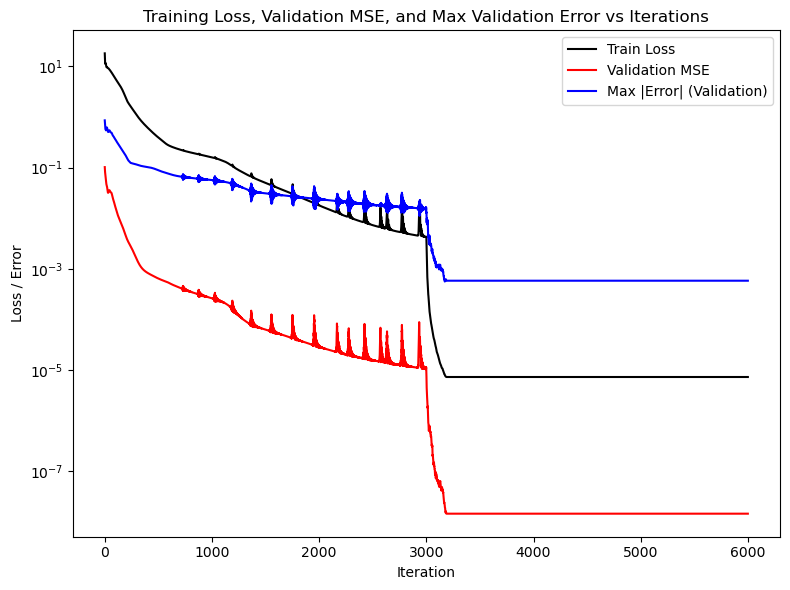

In [18]:
# Prepare data
ep_train = range(len(loss_values))

ep_val  = [int(i) for i, _ in mse_v_hist]
mse_val = [ (m.detach().cpu().item() if torch.is_tensor(m) else float(m))
                 for _, m in mse_v_hist ]

# --- NEW: prepare max error data ---
ep_max   = [int(i) for i, _ in max_errors]
max_errs = [
    (m.detach().cpu().item() if torch.is_tensor(m) else float(m))
    for _, m in max_errors
]

plt.figure(figsize=(8, 6))
plt.plot(ep_train, loss_values, color='black', label='Train Loss')
plt.plot(ep_val,   mse_val,     color='red',   label='Validation MSE')
plt.plot(ep_max,   max_errs,    color='blue',  label='Max |Error| (Validation)')  # <<< NEW

plt.xlabel('Iteration')
plt.ylabel('Loss / Error')
plt.yscale('log')
plt.title('Training Loss, Validation MSE, and Max Validation Error vs Iterations')
plt.legend()
plt.tight_layout()
plt.show()

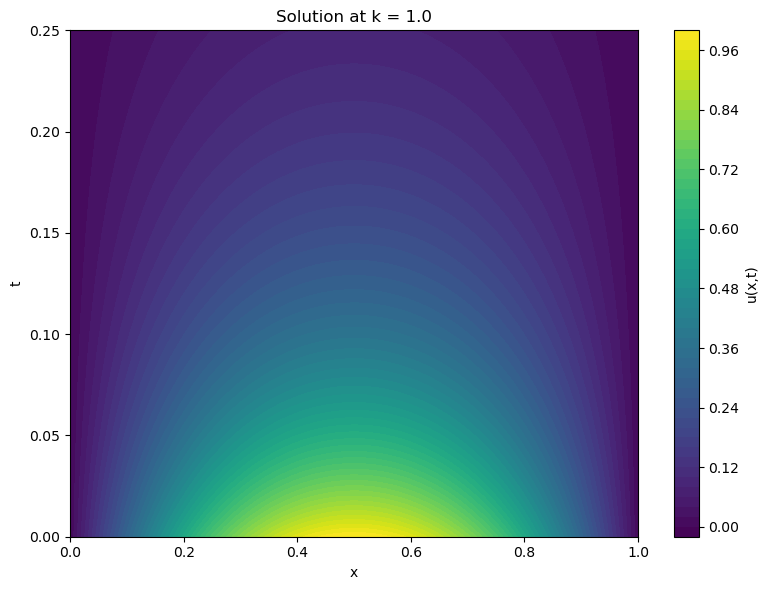

In [19]:
x_test = np.linspace(x_min, x_max, 100)
t_test = np.linspace(t_min, t_max, 100)
k_val  = 1.0
logk_val = np.log10(k_val)

T, X = np.meshgrid(t_test, x_test, indexing='ij')  # (Nt, Nx)
LOGK = np.full_like(T, logk_val)                         # (Nt, Nx)

x_flat    = X.ravel()[:, None]
t_flat    = T.ravel()[:, None]
logk_flat = LOGK.ravel()[:, None]

X_star = np.hstack([x_flat, t_flat, logk_flat]).astype(np.float32)
X_star_tf = torch.from_numpy(X_star).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(X_star_tf).squeeze(1).cpu().numpy().reshape(T.shape)  # (Nt, Nx)

plt.figure(figsize=(8, 6))
cf = plt.contourf(X, T, u_pred, levels=50, cmap='viridis')
plt.colorbar(cf, label='u(x,t)')
plt.xlabel('x'); plt.ylabel('t')
plt.title(f"Solution at k = {k_val}")
plt.tight_layout()
plt.show()

Global relative L2 error: 2.826e-04


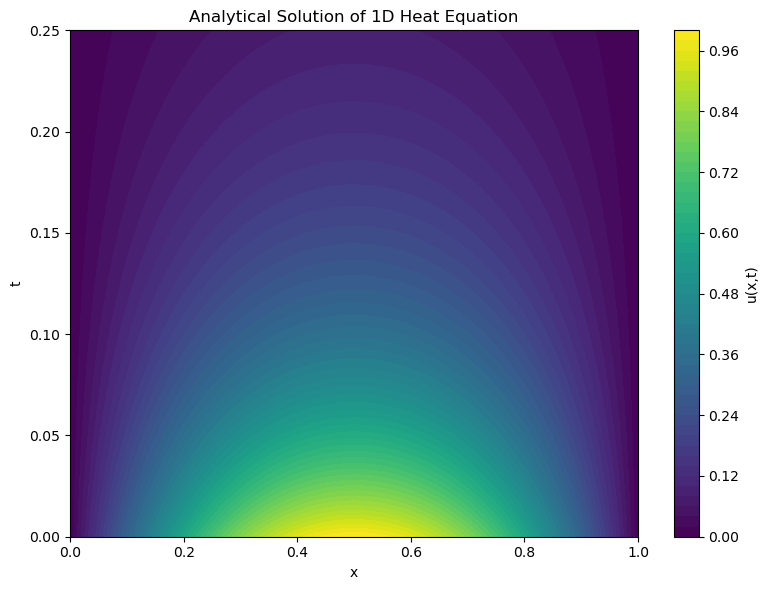

In [20]:
# Analytical solution on the same grid
u_true = u_true_numpy(X, T, LOGK)

num = np.linalg.norm(u_pred - u_true)
den = np.linalg.norm(u_true)
rel_L2 = num / den if den > 0 else num  # if all-zeros true, fall back to absolute norm
print(f"Global relative L2 error: {rel_L2:.3e}")

plt.figure(figsize=(8, 6))
cf = plt.contourf(X, T, u_true, levels=50, cmap='viridis')
plt.colorbar(cf, label='u(x,t)')
plt.xlabel('x'); plt.ylabel('t')
plt.title("Analytical Solution of 1D Heat Equation")
plt.tight_layout(); plt.show()

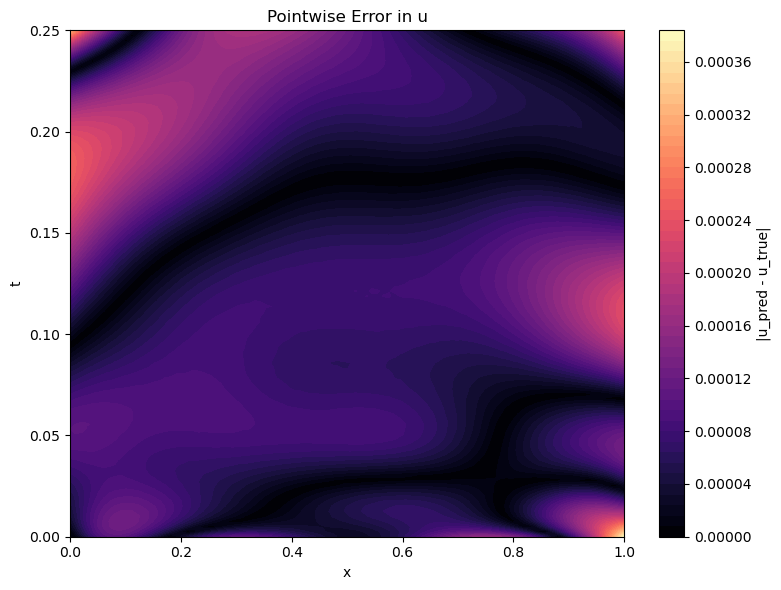

In [21]:
# --- Pointwise error for u ---
err_u = np.abs(u_pred - u_true)

plt.figure(figsize=(8, 6))
cf = plt.contourf(X, T, err_u, levels=50, cmap='magma')
plt.colorbar(cf, label='|u_pred - u_true|')
plt.xlabel('x'); plt.ylabel('t'); plt.title('Pointwise Error in u')
plt.tight_layout(); plt.show()

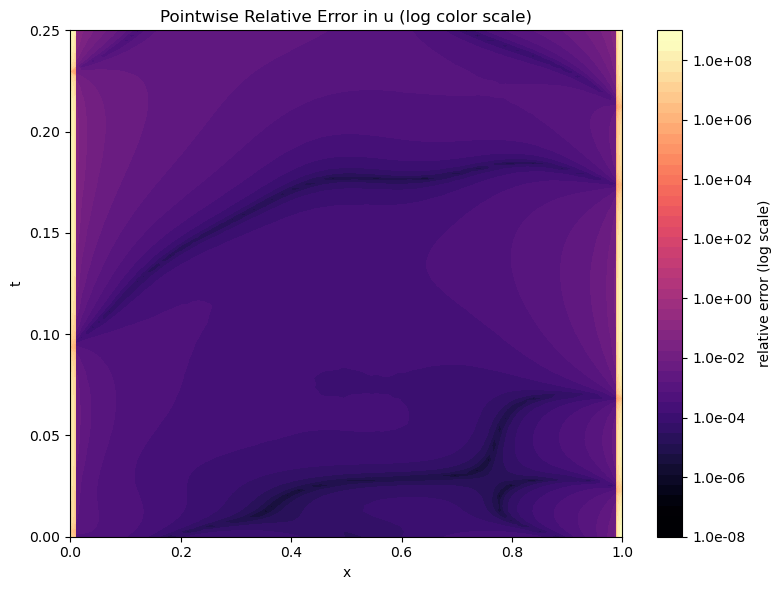

In [22]:
# Pointwise relative error: |pred - true| / max(|true|, eps)
eps = 1e-12
den = np.maximum(np.abs(u_true), eps)
err_rel = np.abs(u_pred - u_true) / den
err_plot = np.clip(err_rel, eps, None)

vmin, vmax = err_plot.min(), err_plot.max()

# log-spaced levels across powers of 10
lo = np.floor(np.log10(vmin))
hi = np.ceil(np.log10(vmax))
levels = np.logspace(lo, hi, 50)

fig, ax = plt.subplots(figsize=(8, 6))
cf = ax.contourf(X, T, err_plot, levels=levels,
                 norm=LogNorm(vmin=vmin, vmax=vmax), cmap='magma')

# --- Colorbar with custom ticks & formatting ---
cbar = fig.colorbar(cf, ax=ax, label='relative error (log scale)')

# Choose which log ticks you want: only powers of 10, or include 2 & 5 too
# powers of 10 only:
cbar.locator = LogLocator(base=10, subs=(1.0,))        # ticks at 1eN
# or denser: cbar.locator = LogLocator(base=10, subs=(1.0, 2.0, 5.0))

# Scientific formatting (3 digits); e.g., 1.23e-03
cbar.formatter = FuncFormatter(lambda x, pos: f"{x:.1e}")
cbar.update_ticks()

ax.set_xlabel('x'); ax.set_ylabel('t')
ax.set_title('Pointwise Relative Error in u (log color scale)')
fig.tight_layout()
plt.show()

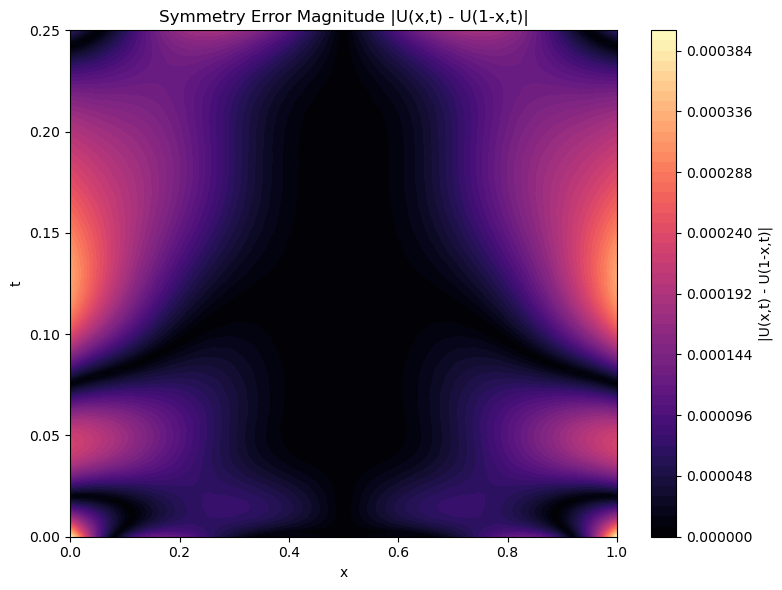

In [23]:
# --- Symmetry error over the whole (x,t) grid ---
# Mirror across x=0.5 by flipping columns
U_mirror = u_pred[:, ::-1]                 # same shape as U_pred
E_sym = u_pred - U_mirror                  # antisymmetric part
AbsE = np.abs(E_sym)                       # magnitude of asymmetry

plt.figure(figsize=(8, 6))
cf = plt.contourf(X, T, AbsE, levels=50, cmap='magma')
plt.colorbar(cf, label='|U(x,t) - U(1-x,t)|')
plt.xlabel('x'); plt.ylabel('t')
plt.title('Symmetry Error Magnitude |U(x,t) - U(1-x,t)|')
plt.tight_layout()
plt.show()

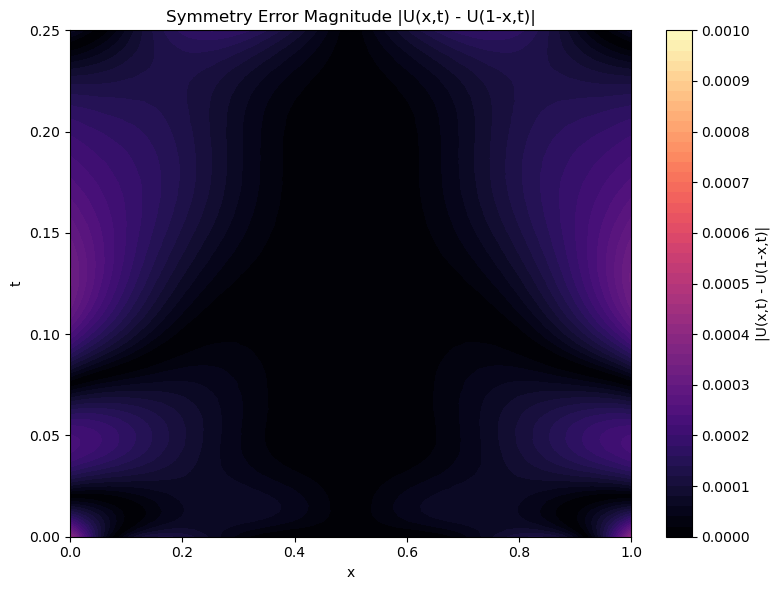

In [24]:
plt.figure(figsize=(8, 6))
levels = np.linspace(0.0, 0.001, 51)  # 0 → 0.002
cf = plt.contourf(X, T, AbsE, levels=levels, cmap='magma', vmin=0.0, vmax=0.001)
cbar = plt.colorbar(cf, label='|U(x,t) - U(1-x,t)|')
cbar.set_ticks([0.0000, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.0010])
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.xlabel('x'); plt.ylabel('t')
plt.title('Symmetry Error Magnitude |U(x,t) - U(1-x,t)|')
plt.tight_layout()
plt.show()

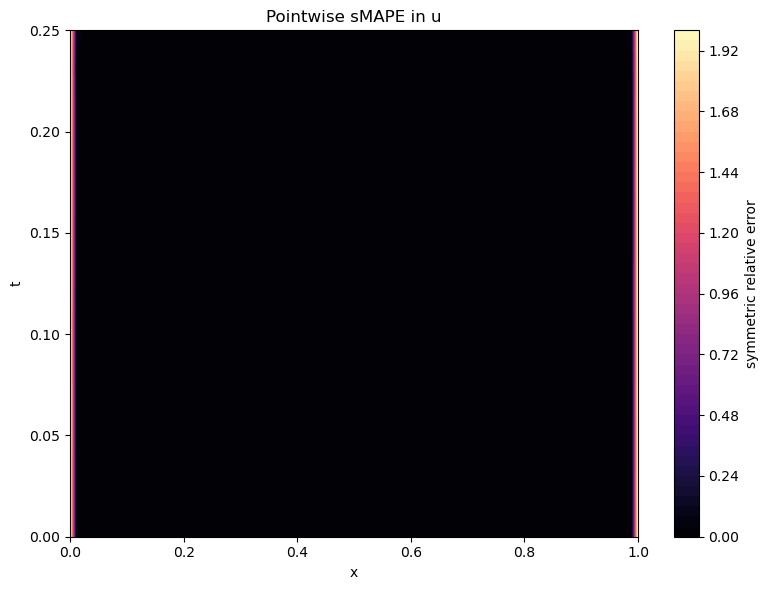

In [25]:
# sMAPE: |pred - true| / ( (|pred| + |true|)/2 + eps )
eps = 1e-12
err_smapE = np.abs(u_pred - u_true) / (0.5*(np.abs(u_pred) + np.abs(u_true)) + eps)

plt.figure(figsize=(8, 6))
cf = plt.contourf(X, T, err_smapE, levels=50, cmap='magma')
plt.colorbar(cf, label='symmetric relative error')
plt.xlabel('x'); plt.ylabel('t'); plt.title('Pointwise sMAPE in u')
plt.tight_layout(); plt.show()

<div style="padding: 10px;">

# Use trained model to predict from data sample
    
The function `evaluate` will evaluate the solution `u` on a given grid using the trained model

</div>

In [26]:
# def evaluate(model, x_star, t_star):
#     """
#     Evaluate the solution u and the residual f of the 1D heat equation using the trained PINN model.

#     Parameters:
#     model (torch.nn.Module): The trained Physics-Informed Neural Network model.
#     x_star (numpy.ndarray): Array of spatial points where predictions are to be made.
#     t_star (numpy.ndarray): Array of temporal points where predictions are to be made.

#     Returns:
#     tuple: A tuple containing:
#         - u_star (numpy.ndarray): Predicted solution at the given spatial and temporal points.
#         - f_star (numpy.ndarray): Predicted residual of the PDE at the given spatial and temporal points.
#     """

#     # 1) Use the model's device
#     dev = next(model.parameters()).device

#     # Convert input spatial points to a PyTorch tensor with gradient tracking enabled
#     x_star_tf = torch.tensor(x_star, dtype=torch.float32, device=dev, requires_grad=True)
#     # Convert input temporal points to a PyTorch tensor with gradient tracking enabled
#     t_star_tf = torch.tensor(t_star, dtype=torch.float32, device=dev, requires_grad=True)
#     # Evaluate the solution u using the model
#     u_star = net_u(x_star_tf, t_star_tf, model)
#     # Evaluate the residual f of the PDE using the model
#     f_star = net_f(x_star_tf, t_star_tf, model)

#     # Detach the Evaluations from the computation graph and convert to NumPy arrays
#     return u_star.detach().cpu().numpy(), f_star.detach().cpu().numpy()

In [27]:
# u_eval, f_eval = evaluate(model,X_star[:,0:1],X_star[:,1:2])

# u_pred = net_u(x_tf, t_tf, model )
# f_pred = net_f(x_f_t, t_f_t, model)

# error_u = np.linalg.norm(u_star-u_eval,2)/np.linalg.norm(u_star,2)

<div style="padding: 10px;">

# Diagnostics: Errors
    
</div>

In [28]:
# print("Mean of physics residual = ", np.mean(f_eval))
# print('Percent error in solution: ',  100*error_u)

<div style="padding: 10px;">

# Plots of original, reconstructed solutions $u(x,t)$ and their difference
    


</div>

In [29]:
# # Set grid values back to full data set size for plotting

# t = data['t'].flatten()[:,None]
# x = data['x'].flatten()[:,None]
# X, T = np.meshgrid(x,t)

# U_pred = u_eval.reshape(Exact.shape)
# Error = np.abs(Exact - U_pred)
# percentError = 100*np.divide(Error, Exact)


# fig, ax = plt.subplots(figsize=(15,15))
# ax.axis('off')

# t = data['t'].flatten()[:,None]
# x = data['x'].flatten()[:,None]
# X, T = np.meshgrid(x,t)

# U_pred = u_eval.reshape(Exact.shape)
# Error = np.abs(Exact - U_pred)
# percentError = 100*np.divide(Error, Exact)


# ####### Row 0: u(t,x) ##################
# gs0 = gridspec.GridSpec(3, 1)
# gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0, hspace=1)


# ########## Prediction ##################
# ax = plt.subplot(gs0[0, :])
# h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
#               extent=[t.min(), t.max(), x.min(), x.max()],
#               origin='lower', aspect='auto', vmin = 0, vmax = 1)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(h, cax=cax)

# ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

# line = np.linspace(x.min(), x.max(), 2)[:,None]
# ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

# ax.set_xlabel('$t$')
# ax.set_ylabel('$x$')
# ax.legend(frameon=False, loc = 'best')
# ax.set_title('$u(t,x) - Prediction$', fontsize = 10)

# ########## Exact ##################
# ax = plt.subplot(gs0[1, :])
# i = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
#               extent=[t.min(), t.max(), x.min(), x.max()],
#               origin='lower', aspect='auto', vmin = 0, vmax = 1)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(i, cax=cax)

# ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

# line = np.linspace(x.min(), x.max(), 2)[:,None]
# ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

# ax.set_xlabel('$t$')
# ax.set_ylabel('$x$')
# ax.legend(frameon=False, loc = 'best')
# ax.set_title('$u(t,x)$ - Exact', fontsize = 10)

# ########## Error ##################
# ax = plt.subplot(gs0[2, :])
# j = ax.imshow(percentError.T, interpolation='nearest', cmap='rainbow',
#               extent=[t.min(), t.max(), x.min(), x.max()],
#               origin='lower', aspect='auto', vmin = 0, vmax = 10)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(j, cax=cax)

# ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

# line = np.linspace(x.min(), x.max(), 2)[:,None]
# ax.plot(t[2]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[10]*np.ones((2,1)), line, 'w-', linewidth = 1)

# ax.set_xlabel('$t$')
# ax.set_ylabel('$x$')
# ax.legend(frameon=False, loc = 'best')
# ax.set_title('$u(t,x)$ - Percent difference', fontsize = 10)


# ####### Row 1: u(t,x) slices ##################

# fig, ax = plt.subplots(figsize=(15,5))
# ax.axis('off')
# gs1 = gridspec.GridSpec(1, 3)
# gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

# ax = plt.subplot(gs1[:, 0])
# ax.plot(x,Exact[2,:], 'b-', linewidth = 2, label = 'Exact')
# ax.plot(x,U_pred[2,:], 'r--', linewidth = 2, label = 'Prediction')
# ax.set_xlabel('$x$')
# ax.set_ylabel('$u(t,x)$')
# ax.set_title('$t = ' + str(t[2,0]) + '$', fontsize = 10)
# ax.axis('square')
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])

# ax = plt.subplot(gs1[:, 1])
# ax.plot(x,Exact[5,:], 'b-', linewidth = 2, label = 'Exact')
# ax.plot(x,U_pred[5,:], 'r--', linewidth = 2, label = 'Prediction')
# ax.set_xlabel('$x$')
# ax.set_ylabel('$u(t,x)$')
# ax.axis('square')
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
# ax.set_title('$t = ' + str(t[5,0]) + '$', fontsize = 10)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

# ax = plt.subplot(gs1[:, 2])
# ax.plot(x,Exact[10,:], 'b-', linewidth = 2, label = 'Exact')
# ax.plot(x,U_pred[10,:], 'r--', linewidth = 2, label = 'Prediction')
# ax.set_xlabel('$x$')
# ax.set_ylabel('$u(t,x)$')
# ax.axis('square')
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
# ax.set_title('$t = ' + str(t[10,0]) + '$', fontsize = 10);


<div style="padding: 10px;">

## Summary of results

The relative error for recreating the full solution is at most $\approx 5 \%$ (and mostly much smaller), despite using only $N_u = 100$ data points. This shows the power of PINNs to learn from sparse measurements by augmenting the available observational data with knowledge of the underlying physics (i.e. governing equations).

We can see that the errors are largest near $t=0$ and $x=0$, but that overall the agreement is very good.

On the colourmap, we can see three vertical white lines, which show the location in time of the three profile plots of $u$ against $x$. The three heat profiles at these times are plotted against the exact solution found using numerical methods. The profiles can be seen to be in very good agreement.

**Further Work**

Congratulations, you have now trained your first physics-informed neural network!

This network contains a number of hyper-parameters that could be tuned to give better results. Various hyper-parameters include:
- number of data training points N_u
- number of collocation training points N_f
- number of layers in the network
- number of neurons per layer
- weightings for the data and PDE loss terms in the loss function (currently we use loss = loss_PDE + 5*loss_data)

It is also possible to use different sampling techniques for training data points. We randomly select $N_u$ data points, but alternative methods could be choosing only boundary points or choosing more points near the $t=0$ boundary. Choosing boundary points for training could help to reduce the errors seen in these regions.

Feel free to try out some of these changes if you like!

</div>

In [30]:
# lb = np.array([0.0, 0.0], dtype=np.float32)
# ub = np.array([1.0, 0.25], dtype=np.float32)
# U = lhs(2, samples=5)   # shape (N_f, 2)
# X_f_train = lb + (ub-lb) * U # the 2 denotes the number of coordinates we have - x,t
# print(lb)
# print(ub)
# print(U)
# print(X_f_train)